# Converting efficientnet-edgetpu from Tensorflow to ONNX

Setup some environment, download model source and pre-trained model:

In [1]:
import os
HOME = os.getcwd()
MODEL = "efficientnet-edgetpu-L"
os.environ['PYTHONPATH'] = os.path.join(HOME, "tpu")
os.environ['MODEL'] = MODEL
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [ ]:
!git clone https://github.com/tensorflow/tpu

In [3]:
%cd {HOME}/tpu/models/official/efficientnet

/home/gs/edge/tpu/models/official/efficientnet


In [ ]:
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/$MODEL.tar.gz
!tar zxf $MODEL.tar.gz
!wget https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG -O panda.jpg
!wget https://storage.googleapis.com/cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.txt

Run a evaluation on tensorflow/cpu:

In [6]:
!python eval_ckpt_main.py --model_name=$MODEL --ckpt_dir=$MODEL --example_img=panda.jpg --labels_map_file=labels_map.txt --include_background_label

  -> top_0 (87.89%): giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca  
  -> top_1 (0.89%): ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus  
  -> top_2 (0.45%): American black bear, black bear, Ursus americanus, Euarctos americanus  
  -> top_3 (0.34%): brown bear, bruin, Ursus arctos  
  -> top_4 (0.18%): white wolf, Arctic wolf, Canis lupus tundrarum  


Lets take a look at the pre-trained model:

In [7]:
!saved_model_cli show --dir $MODEL/saved_model/ --tag_set serve  --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['input'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 300, 300, 3)
      name: images:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output'] tensor_info:
      dtype: DT_FLOAT
      shape: (1, 1001)
      name: Softmax:0
Method name is: tensorflow/serving/predict


Install and run tf2onnx directly on the saved_model:

In [ ]:
!pip install -U tf2onnx

In [8]:
!python -m tf2onnx.convert --opset 11 --fold_const --saved-model $MODEL/saved_model --output $MODEL.onnx

2020-01-22 12:52:13,681 - WARNING - From /home/gs/tensorflow-onnx/tf2onnx/verbose_logging.py:72: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-01-22 12:52:14.948374: E tensorflow/stream_executor/cuda/cuda_driver.cc:318] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-01-22 12:52:17,258 - INFO - Using tensorflow=1.15.0, onnx=1.6.0, tf2onnx=1.6.0/342270
2020-01-22 12:52:17,258 - INFO - Using opset <onnx, 11>
2020-01-22 12:52:17,912 - INFO - Optimizing ONNX model
2020-01-22 12:52:19,343 - INFO - After optimization: Add -72 (93->21), Const -17 (163->146), Identity -3 (3->0), Reshape -16 (16->0), Transpose -158 (160->2)
2020-01-22 12:52:19,357 - INFO - 
2020-01-22 12:52:19,357 - INFO - Successfully converted TensorFlow model efficientnet-edgetpu-L/saved_model to ONNX
2020-01-22 12:52:19,475 - INFO - ONNX model is saved at efficientnet-edgetpu-L.onnx


Now that we have the ONNX model we can write a quick demo using onnxruntime:

In [ ]:
!pip install onnxruntime

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


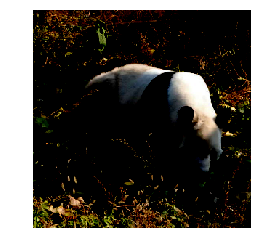

In [9]:
%matplotlib inline

import numpy as np
import math
import matplotlib.pyplot as plt
import onnxruntime as rt
import cv2
import json

labels = json.load(open("labels_map.txt", "r"))


def img_stats(a, name={}):
    return {
        "name": name,
        "size": a.shape,
        "mean": "{:.2f}".format(a.mean()),
        "std": "{:.2f}".format(a.std()),
        "max": a.max(),
        "min": a.min(),
        "median": "{:.2f}".format(np.median(a)),
    }


def center_crop(img, out_height, out_width):
    height, width, _ = img.shape
    left = int((width - out_width) / 2)
    right = int((width + out_width) / 2)
    top = int((height - out_height) / 2)
    bottom = int((height + out_height) / 2)
    img = img[top:bottom, left:right]
    return img


def resize_with_aspectratio(img, out_height, out_width, scale=87.5, inter_pol=cv2.INTER_LINEAR):
    height, width, _ = img.shape
    new_height = int(100. * out_height / scale)
    new_width = int(100. * out_width / scale)
    if height > width:
        w = new_width
        h = int(new_height * height / width)
    else:
        h = new_height
        w = int(new_width * width / height)
    img = cv2.resize(img, (w, h), interpolation=inter_pol)
    return img


def pre_process_mobilenet(img, dims):
    output_height, output_width, _ = dims
    img = resize_with_aspectratio(img, output_height, output_width, inter_pol=cv2.INTER_LINEAR)
    img = center_crop(img, output_height, output_width)
    img = np.asarray(img, dtype='float32')

    img /= 255.0
    img -= 0.5
    img *= 2
    return img

def pre_process_edgetpu(img, dims):
    output_height, output_width, _ = dims
    img = resize_with_aspectratio(img, output_height, output_width, inter_pol=cv2.INTER_LINEAR)
    img = center_crop(img, output_height, output_width)
    img = np.asarray(img, dtype='float32')
    img -= [127.0, 127.0, 127.0]
    img /= [128.0, 128.0, 128.0]
    return img


# read the image
fname = "panda.jpg"
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# pre-process the image like mobilenet and resize it to 300x300
img = pre_process_edgetpu(img, (300, 300, 3))
plt.axis('off')
plt.imshow(img)
plt.show()

# create a batch of 1 (that batch size is buned into the saved_model)
img_batch = np.expand_dims(img, axis=0)

In [10]:
# load the model
sess = rt.InferenceSession(MODEL + ".onnx")

In [11]:
# run inference and print results
results = sess.run(["Softmax:0"], {"images:0": img_batch})[0]
result = reversed(results[0].argsort()[-5:])
# result = np.argmax(results, axis=1)
for r in result:
    print(r, labels[str(r-1)], results[0][r])

389 giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca 0.9173779
297 ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus 0.005915898
296 American black bear, black bear, Ursus americanus, Euarctos americanus 0.0036560348
295 brown bear, bruin, Ursus arctos 0.0026371442
388 lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens 0.001314711
